In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from ast import literal_eval

# Gensim
from gensim.models import KeyedVectors

# Keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping

# TensorFlow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import legacy

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Membaca data
train_data = pd.read_csv('../../../../Data/5. Split/under/train_data_70_30_under.csv')
validation_data = pd.read_csv('../../../../Data/5. Split/under/validation_data_70_30_under.csv')
test_data = pd.read_csv('../../../../Data/5. Split/under/test_data_70_30_under.csv')

In [3]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data['text_tokenize'].apply(literal_eval)
y_train = train_data.label

x_validation = validation_data['text_tokenize'].apply(literal_eval)
y_validation = validation_data.label

x_test = test_data['text_tokenize'].apply(literal_eval)
y_test = test_data.label

Word2Vec

In [4]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('../../../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('../../../../Model/w2v_model_ug_sg.word2vec')

In [5]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7349


In [6]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

Found 7349 word vectors.


In [7]:
# Membuat tokenizer dengan jumlah kata maksimum 
tokenizer = Tokenizer(num_words=unique_words_count)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

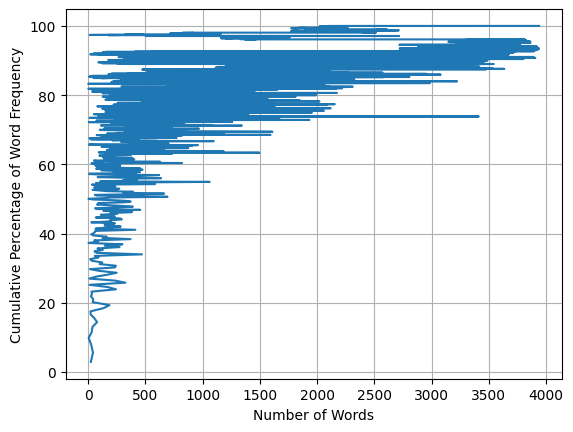

Number of words for 99% coverage: 3626


In [8]:
# Menampilkan frekuensi kata dalam bentuk DataFrame
word_freq = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word', 'count'])
word_freq = word_freq.sort_values('count', ascending=False)

# Plot distribusi kumulatif
word_freq['cumulative_percentage'] = (word_freq['count'].cumsum() / word_freq['count'].sum()) * 100
plt.plot(word_freq['cumulative_percentage'])
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Percentage of Word Frequency')
plt.grid()
plt.show()

# Memilih persentase yang diinginkan
desired_percentage = 99
num_words = word_freq[word_freq['cumulative_percentage'] <= desired_percentage].shape[0]
print(f"Number of words for {desired_percentage}% coverage: {num_words}")


In [9]:
# Menghitung jumlah kata unik dalam tokenizer
unique_token_count = len(tokenizer.word_index)

# Menampilkan jumlah kata unik
print(unique_token_count)

3940


In [10]:
# Menampilkan 5 teks pertama dari data latih (x_train)
for x in x_train[:5]:
    print(x)

['thank', 'lu', 'atas', 'jelas', 'dok', 'review', 'produk', 'cantik', 'kali', 'dong', 'dok', 'sekarang', 'makin', 'banyak', 'produk', 'viral', 'ditiktok', 'bpom', 'penasaran', 'sama', 'sabun', 'sama', 'skincarenya']
['jadi', 'solusi', 'nya', 'obat', 'apa', 'dok', 'anak', 'demam', 'dok']
['anak', 'juga', 'kurang', 'sehat', 'dokter', 'batuk', 'pilek', 'sudah', 'dokter', 'eh', 'obat', 'pahit', 'anak', 'jadi', 'sulit', 'minum', 'obat', 'biasa', 'minum', 'sirup', 'kini', 'maknya', 'yang', 'takut', 'takut', 'kasih', 'sirup']
['sbnrnya', 'dkter', 'richard', 'dkter', 'apa', 'sih', 'heran', 'deh', 'aku', 'suka', 'banget', 'sama', 'reviewnya', 'selalu', 'jlas', 'banget']
['semoga', 'masyarakat', 'makin', 'tahu', 'edukasi', 'baik', 'dokter', 'richard', 'sudah', 'beri', 'review', 'atas', 'produk', 'produk', 'bahaya', 'jadi', 'jangan', 'nekat', 'iya', 'menuduh', 'dokter', 'richard', 'lee', 'aneh', 'aneh', 'karena', 'dokter', 'keren', 'aku']


In [11]:
# Menampilkan urutan indeks kata dari teks pertama dalam data latih (sequences)
print(sequences[:1])

[[617, 561, 92, 45, 4, 299, 211, 685, 135, 136, 4, 23, 227, 20, 211, 313, 1650, 28, 1651, 34, 1158, 34, 1652]]


In [12]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

In [13]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 399


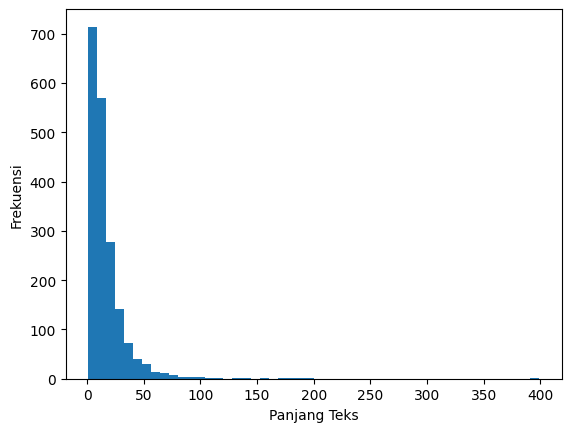

Persentil ke-90: 33.0
Persentil ke-95: 45.0
Persentil ke-99: 84.99000000000001


In [14]:
# Menghitung panjang teks untuk setiap dokumen dalam data latih
text_lengths = [len(text) for text in x_train]

# Membuat histogram untuk melihat distribusi panjang teks
plt.hist(text_lengths, bins=50)
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.show()

# Menghitung persentil ke-90, ke-95, dan ke-99 untuk menentukan max_len yang sesuai
p90 = np.percentile(text_lengths, 90)
p95 = np.percentile(text_lengths, 95)
p99 = np.percentile(text_lengths, 99)

print(f"Persentil ke-90: {p90}")
print(f"Persentil ke-95: {p95}")
print(f"Persentil ke-99: {p99}")

In [15]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = max_word_count

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [16]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

Shape of padded data tensor: (1902, 399)


In [17]:
# Menampilkan 5 sampel pertama dari data latih yang telah dipad (x_train_seq)
print(x_train_seq[:5])


[[   0    0    0 ... 1158   34 1652]
 [   0    0    0 ...    3   51    4]
 [   0    0    0 ...   90   14   13]
 [   0    0    0 ...   39 1655   47]
 [   0    0    0 ...    5  314    8]]


In [18]:
# Mengonversi teks dalam data validation (x_validation) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_validation)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_validation_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_validation_seq berisi data validasi yang telah dipad dan siap digunakan

In [19]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 200)
embedding_matrix = np.zeros((num_words, 200))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index

In [20]:
# Memeriksa kesetaraan antara vektor embedding ke-29 dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[29], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'? False


In [21]:
# Cari indeks kata 'baik' dalam tokenizer.word_index
baik_index = tokenizer.word_index.get('baik')

# Memeriksa kesetaraan antara vektor embedding kata 'baik' dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[baik_index], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'? True


In [22]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_validation_cat = to_categorical(y_validation + 1, num_classes=3)

Pemodelan CNN

In [23]:
# Setting learning rate within the Adam optimizer
Adam = legacy.Adam(learning_rate=0.001)

# Setting the label smoothing within the loss function
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [24]:
# Membuat model Sequential
model_cnn = Sequential()

# Menambahkan layer Embedding
model_cnn.add(Embedding(num_words, 200, input_length=max_len))

# Menambahkan layer Conv1D
model_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# Menambahkan layer Conv1D
model_cnn.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

# Menambahkan layer GlobalMaxPooling1D
model_cnn.add(GlobalMaxPooling1D())

# Menambahkan layer Dense dengan aktivasi ReLU
model_cnn.add(Dense(256, activation='relu'))

# Menambahkan layer Dense output dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnn.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 399, 200)          788200    
                                                                 
 conv1d (Conv1D)             (None, 399, 32)           19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 199, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 64)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0

In [25]:
# Melatih model menggunakan data latihan dan validasi
history_model = model_cnn.fit(x_train_seq, y_train_cat, validation_data=(x_validation_seq, y_validation_cat), epochs=10, batch_size=128, callbacks=[callback], verbose=2)

Epoch 1/10
15/15 - 6s - loss: 1.0947 - accuracy: 0.3665 - val_loss: 1.0849 - val_accuracy: 0.4804 - 6s/epoch - 396ms/step
Epoch 2/10
15/15 - 3s - loss: 1.0387 - accuracy: 0.5862 - val_loss: 1.0050 - val_accuracy: 0.5882 - 3s/epoch - 209ms/step
Epoch 3/10
15/15 - 3s - loss: 0.8283 - accuracy: 0.7718 - val_loss: 0.8251 - val_accuracy: 0.6789 - 3s/epoch - 199ms/step
Epoch 4/10
15/15 - 2s - loss: 0.5633 - accuracy: 0.8812 - val_loss: 0.8047 - val_accuracy: 0.7157 - 2s/epoch - 145ms/step
Epoch 5/10
15/15 - 2s - loss: 0.4275 - accuracy: 0.9516 - val_loss: 0.8124 - val_accuracy: 0.7132 - 2s/epoch - 122ms/step
Epoch 6/10
15/15 - 2s - loss: 0.3622 - accuracy: 0.9826 - val_loss: 0.8291 - val_accuracy: 0.7010 - 2s/epoch - 123ms/step
Epoch 7/10
15/15 - 2s - loss: 0.3298 - accuracy: 0.9942 - val_loss: 0.8289 - val_accuracy: 0.6961 - 2s/epoch - 144ms/step


Evaluasi Pemodelan CNN

In [26]:
model_eval = model_cnn.evaluate(x_validation_seq, y_validation_cat, verbose=0)
print("Akurasi validasi model eksperimen 1: {:.2f}%".format(model_eval[1] * 100))

Akurasi validasi model eksperimen 1: 71.57%


In [30]:
# Mengkonversi teks dalam x_test menjadi urutan token dengan tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan token agar memiliki panjang yang sama
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

# Mengubah label y_test menjadi bentuk one-hot encoding
y_test_cat = to_categorical(y_test + 1, num_classes=3) 

In [31]:
# Menilai model CNN yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
CNN_model_evaluation = model_cnn.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model CNN yang telah dilatih pada data test (x_test_seq)
yhat_cnn = model_cnn.predict(x_test_seq)

13/13 [==============================] - 0s 9ms/step


In [32]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_cnn = np.argmax(yhat_cnn, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [33]:
# Menampilkan classification report untuk kedua model
print("Classification Report (CNN Model):")
print(classification_report(y_true, y_pred_cnn))

Classification Report (CNN Model):
              precision    recall  f1-score   support

          -1       0.70      0.69      0.70       136
           0       0.64      0.64      0.64       136
           1       0.78      0.79      0.78       136

    accuracy                           0.71       408
   macro avg       0.71      0.71      0.71       408
weighted avg       0.71      0.71      0.71       408



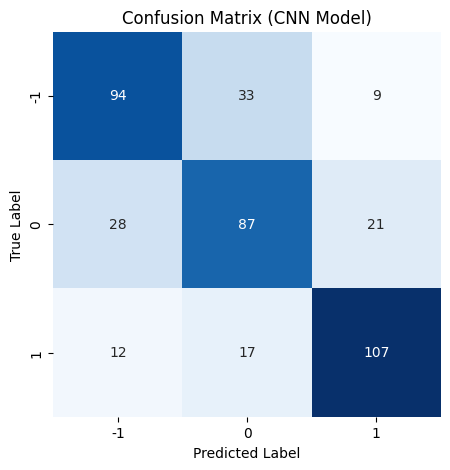

In [35]:
# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_cnn, "Confusion Matrix (CNN Model)")

Output

In [37]:
# Panggil dataset
full_data = pd.read_csv('../../../../Data/3. EDA/clean-eda_.csv')

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_cnn= model_cnn.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_cnn_classes = np.argmax(yhat_full_cnn, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_cnn_classes

full_data.head(10)

150/150 [==============================] - 1s 7ms/step


,video_id,raw,text,predicted_sentiment
0,video1,Baiknya bagaimana menurut kalian?,baik bagaimana turut kalian,0
1,video1,Betul dok betul dok,betul dok betul dok,0
2,video1,Betul dok mungkin efek sa di,betul dok mungkin efek sa,0
3,video1,"Bpom aneh, tidak kerja. Kenapa ko seperti itu.",bpom aneh kerja kok itu,-1
4,video1,Benar banget anak sy aj hrs sirup minum obatny...,benar banget anak aku saja harus sirup minum o...,0
5,video1,Makasih ilmunya dokter semoga berkah🥰🥰🥰🥰,terima kasih ilmu dokter semoga berkah,1
6,video1,Dok tempra gimana? Soalnya anakku kalau demam ...,dok tempra bagaimana soal anak kalau demam kas...,0
7,video1,BIOSOLFON KIDS AMAN GAK KAK,biosolfon kids aman enggak kak,0
8,video1,apa kurang ilmu ya dok,apa kurang ilmu dok,0
9,video1,Cara media massa cari uang.... Memainkan keres...,cara media massa cari uang main resah bingung ...,-1


In [38]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-CNN.csv", index=False)